<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# load dataset
stock_price_df = read_csv('./data/VN30_price.csv', header=0, index_col=0)
stock_price_df = stock_price_df[['VN30']]
values = stock_price_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
stock_price_df.head()

,VN30
2016-12-30,628.21
2017-01-03,633.89
2017-01-04,632.70
2017-01-05,634.83
2017-01-06,636.34


In [2]:
column_names = stock_price_df.columns

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('{}(t-{})'.format(column_names[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('{}(t)'.format(column_names[j])) for j in range(n_vars)]
		else:
			names += [('{}(t+{})'.format(column_names[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
Shift_df = stock_price_df.copy()

In [5]:
for col in column_names:
    stock_price_df["Diff" + column_names] = stock_price_df[column_names].diff()

In [6]:
n_days_lag = 10
n_features = len(column_names)

reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)


In [7]:
reframed.head()

,VN30(t-10),VN30(t-9),VN30(t-8),VN30(t-7),VN30(t-6),VN30(t-5),VN30(t-4),VN30(t-3),VN30(t-2),VN30(t-1),VN30(t)
2017-01-17,5.68,-1.19,2.13,1.51,2.06,0.96,4.03,-1.14,-2.18,-7.37,4.84
2017-01-18,-1.19,2.13,1.51,2.06,0.96,4.03,-1.14,-2.18,-7.37,4.84,-4.44
2017-01-19,2.13,1.51,2.06,0.96,4.03,-1.14,-2.18,-7.37,4.84,-4.44,-2.10
2017-01-20,1.51,2.06,0.96,4.03,-1.14,-2.18,-7.37,4.84,-4.44,-2.10,3.28
2017-01-23,2.06,0.96,4.03,-1.14,-2.18,-7.37,4.84,-4.44,-2.10,3.28,1.14


In [8]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
#y is the VN30 price
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1191, 10) (1191, 1) (298, 10) (298, 1)


In [9]:
test_df = stock_price_df[n_train_days:]
train_df = stock_price_df[:n_train_days]

In [10]:
SVR_model = RandomForestRegressor()
svr = SVR(epsilon=0.2)

# Create the Multioutput Regressor
SVR_model = MultiOutputRegressor(svr)

SVR_model.fit(train_X, train_y)


MultiOutputRegressor(estimator=SVR(epsilon=0.2))

In [11]:
train_idx = stock_price_df.index <= reframed[:n_train_days].index[-1]
test_idx = ~train_idx

train_idx[:n_days_lag+1] = False

In [12]:
SVR_model.score(train_X, train_y)

0.048955531884468995

In [13]:
SVR_model.score(test_X, test_y)

-0.026158454205244874

In [15]:
SVR_model.predict(train_X)[:, 0].shape

(1191,)

In [16]:
for i, col in enumerate(column_names):
    stock_price_df[f'Shift{col}'] = stock_price_df[col].shift(1)
    prev = stock_price_df[f'Shift{col}']
    stock_price_df.loc[train_idx, f'{col}-SVR_1_step_train'] = prev[train_idx] + SVR_model.predict(train_X)[:, i]
    stock_price_df.loc[test_idx, f'{col}-SVR_1_step_test'] = prev[test_idx] + SVR_model.predict(test_X)[:, i]

In [17]:
observe_date = reframed[n_train_days-10:].index[0]

<Axes: >

<Figure size 1000x600 with 0 Axes>

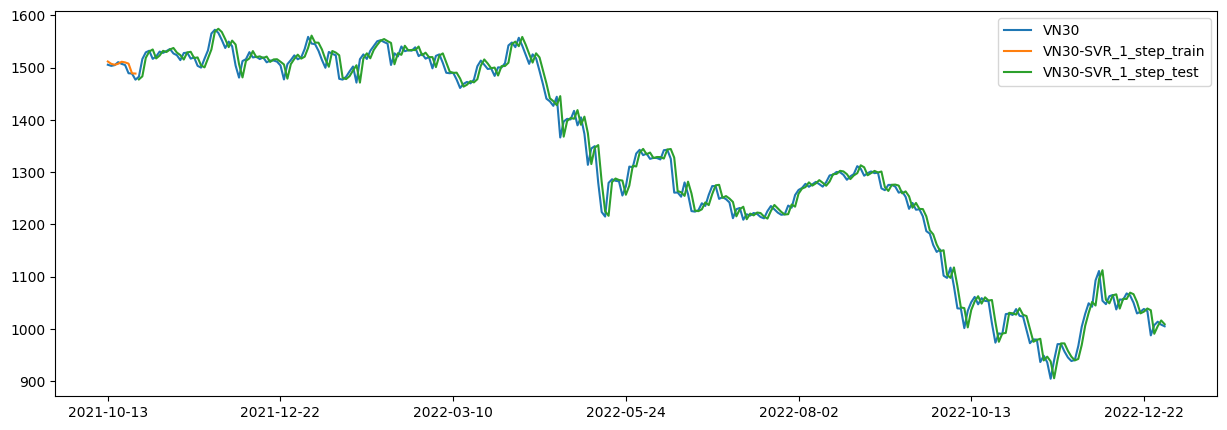

In [18]:
plt.figure(figsize=(10, 6))
stock_price_df[stock_price_df.index > observe_date][['VN30', 'VN30-SVR_1_step_train', 'VN30-SVR_1_step_test']].plot(figsize=(15,5))

In [19]:
test_X[[0], :].shape

(1, 10)

In [20]:
test_X

array([[ -0.7 ,  -4.02,  -2.17, ..., -15.77,  -0.55, -11.74],
       [ -4.02,  -2.17,   1.46, ...,  -0.55, -11.74,   5.65],
       [ -2.17,   1.46,   5.65, ..., -11.74,   5.65,  33.84],
       ...,
       [ -0.26,  11.91,  -4.01, ...,  -4.21, -46.36,  19.59],
       [ 11.91,  -4.01, -13.85, ..., -46.36,  19.59,   6.59],
       [ -4.01, -13.85, -20.43, ...,  19.59,   6.59,  -5.65]])

In [21]:
n_observe_days = 5
multistep_forecasting = []
last_x = test_X[[0]]
while len(multistep_forecasting) < n_observe_days:
    p = SVR_model.predict(last_x)
    multistep_forecasting.append(p)
    last_x = np.roll(last_x, -n_features)
    for i in range(n_features):
        last_x[0, -(n_features-i)] = p[0, i]


In [22]:
import copy
multistep_idx = copy.deepcopy(test_idx)
multistep_idx[n_train_days+n_days_lag+1+n_observe_days:] = False
multistep_idx.sum()

5

In [23]:
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-SVR_multistep'] = last_train + np.cumsum([p[0,i] for  p in multistep_forecasting])

<Axes: >

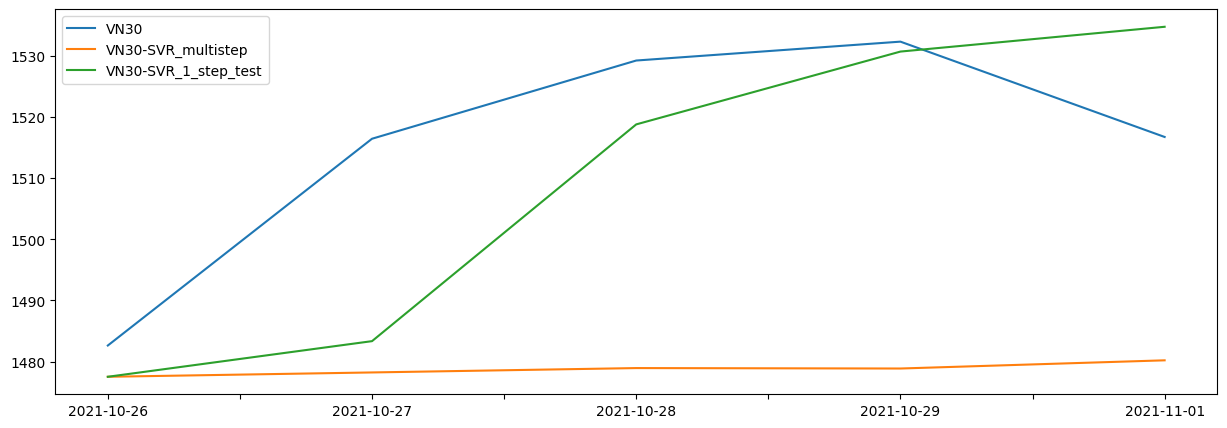

In [24]:
stock_price_df[multistep_idx][['VN30', 'VN30-SVR_multistep', 'VN30-SVR_1_step_test']].plot(figsize=(15,5))

In [ ]:
from joblib import dump, load

dump(SVR_model, 'SVR_model.joblib')

SVR_model = load('SVR_model.joblib')


Shift_df = stock_price_df.copy()
for col in column_names:
    stock_price_df[f"Diff{col}"] = stock_price_df[col].diff()

n_days_lag = 10
n_features = len(column_names)
reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)
n_obs = n_days_lag * n_features

last_input_sequence = reframed.values[-1:, :n_obs]



In [ ]:
last_input_sequence.shape

(1, 220)

In [ ]:
a = []
b = np.random.rand(1, 22)
a.append(b)

In [ ]:
prediction = SVR_model.predict(last_input_sequence)
prediction.shape

(1, 22)

In [ ]:
last_values = stock_price_df[column_names].iloc[-1]
last_values.shape

(22,)

PREDICT HERE

In [ ]:
from joblib import dump, load

dump(SVR_model, 'save/SVR_model.joblib')

SVR_model = load('save/SVR_model.joblib')


Shift_df = stock_price_df.copy()
for col in column_names:
    stock_price_df[f"Diff{col}"] = stock_price_df[col].diff()

n_days_lag = 10
n_features = len(column_names)
reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)
n_obs = n_days_lag * n_features

last_input_sequence = reframed.values[-1:, :n_obs]


predictions = []
last_values = stock_price_df[column_names].iloc[-1].values.reshape(1, n_features)
n_predict = 5
for i in range(n_predict):
    prediction = SVR_model.predict(last_input_sequence)

    prediction = prediction.reshape((1, n_features))


    last_input_sequence = np.roll(last_input_sequence, -n_features)
    last_input_sequence[:, -n_features:] = prediction
    # print(type(prediction))
    last_values = last_values + prediction
    predictions.append(last_values)
predictions = np.array(predictions).reshape(n_predict, n_features)
predictions.shape
predicted_values_df = pd.DataFrame(data=predictions, columns=column_names)
predicted_values_df

,BID,BVH,CTG,FPT,GAS,HPG,KDH,MBB,MSN,MWG,...,PNJ,REE,SBT,SSI,STB,TCH,VCB,VIC,VNM,VN30
0,38601.539501,46599.617505,27249.998460,76928.199741,101503.477836,18013.292538,26499.270991,17101.329033,93000.398905,42929.791456,...,89901.677376,71500.091890,14500.084988,17700.202031,22498.854468,6828.365585,80000.598134,53800.557588,76099.392491,1005.609060
1,38601.521809,46600.213069,27247.237898,76957.325287,101508.501657,18027.253845,26498.476252,17101.839260,93001.135701,42959.219636,...,89903.680862,71500.528565,14500.702695,17700.067720,22497.528428,6867.180925,80000.765638,53801.466240,76098.720210,1006.929630
2,38602.571131,46599.796699,27245.728986,76984.107836,101512.408851,18039.582086,26497.747512,17102.138472,93000.468301,42986.766769,...,89902.855336,71499.720827,14500.550575,17699.662362,22496.594550,6904.777170,80000.076052,53801.188916,76097.747962,1007.230487
3,38602.843178,46598.854466,27245.385917,77011.836163,101515.370608,18051.922085,26497.165434,17102.038805,93000.740997,43014.491324,...,89904.467270,71499.344211,14498.939999,17698.914154,22496.536196,6941.282301,80000.191375,53800.769711,76098.045074,1008.026663
4,38604.501818,46599.789797,27244.771198,77039.565871,101517.503118,18067.027498,26497.939638,17102.826115,93000.598159,43045.733044,...,89906.076411,71500.561695,14498.555060,17699.206194,22497.109525,6978.214110,79999.850281,53801.807788,76098.043932,1009.709259


In [ ]:
multiouput_df = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, n_observe_days)
n_obs = n_days_lag * n_features

values = multiouput_df.values
n_train_days = int(len(multiouput_df.index) * 0.9)
train_m = values[:n_train_days, :]
test_m = values[n_train_days:n_train_days+n_observe_days, :]
train_X_m, train_y_m = train_m[:, :n_obs], train_m[:, n_obs:]
test_X_m, test_y_m = test_m[:, :n_obs], test_m[:, n_obs:]
multioutput_SVR_model = RandomForestRegressor()
mo_svr = SVR(epsilon=0.2)
multioutput_SVR_model = MultiOutputRegressor(mo_svr)
multioutput_SVR_model.fit(train_X_m, train_y_m)
multioutput_SVR_model.score(train_X_m, train_y_m)

0.0030913994151927707

In [ ]:
multiouput_df

,BID(t-10),BVH(t-10),CTG(t-10),FPT(t-10),GAS(t-10),HPG(t-10),KDH(t-10),MBB(t-10),MSN(t-10),MWG(t-10),...,PNJ(t+4),REE(t+4),SBT(t+4),SSI(t+4),STB(t+4),TCH(t+4),VCB(t+4),VIC(t+4),VNM(t+4),VN30(t+4)
2017-01-17,704.5,1100.0,1050.0,306.2,-500.0,133.4,-23.1,-92.0,400.0,83.0,...,0.0,-750.0,-81.7,-72.9,50.0,0.0,75.0,0.0,790.0,1.14
2017-01-18,222.5,800.0,300.0,144.1,1400.0,0.0,0.0,-55.2,-1267.0,70.0,...,-99.7,500.0,0.0,24.3,300.0,-108.1,371.0,-413.0,0.0,3.90
2017-01-19,-37.1,1000.0,100.0,-54.0,0.0,15.7,-253.6,-36.8,-266.0,59.0,...,132.9,350.0,-81.8,72.9,350.0,216.2,519.0,413.0,790.0,5.47
2017-01-20,259.6,300.0,150.0,-54.0,-1100.0,-109.9,138.4,92.0,66.0,0.0,...,498.5,300.0,-245.3,218.6,-150.0,-108.1,111.0,413.0,3159.0,8.19
2017-01-23,333.7,200.0,450.0,90.0,100.0,-39.2,0.0,-18.4,-400.0,-129.0,...,-133.0,-100.0,0.0,-72.9,0.0,-72.1,-556.0,-413.0,711.0,-1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,-2150.0,-2500.0,-1600.0,-2300.0,-3700.0,-1400.0,-1550.0,-1300.0,-3000.0,-3250.0,...,-450.0,-3600.0,-1000.0,-1250.0,-1600.0,-480.0,-200.0,-2200.0,-200.0,-46.36
2022-12-21,-100.0,300.0,350.0,500.0,-2700.0,-350.0,350.0,-400.0,-2000.0,500.0,...,0.0,1700.0,100.0,1150.0,600.0,420.0,200.0,500.0,600.0,19.59
2022-12-22,0.0,200.0,450.0,500.0,-800.0,650.0,400.0,800.0,-4000.0,1150.0,...,1500.0,-200.0,450.0,-50.0,400.0,0.0,900.0,100.0,400.0,6.59
2022-12-23,200.0,-600.0,250.0,1000.0,0.0,300.0,-250.0,100.0,1000.0,200.0,...,3500.0,0.0,200.0,-550.0,-550.0,-40.0,700.0,100.0,0.0,-5.65


In [ ]:
multioutput_SVR_model.score(test_X_m, test_y_m)

-0.5692859722092319

In [ ]:
test_X_m[[0]].shape

(1, 220)

In [ ]:
multioutput_SVR_model.predict(test_X_m[[0]])[0,5]

3.7811891917713405

In [ ]:
multiouput_predict = multioutput_SVR_model.predict(test_X_m[[0]])
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-SVR_multioutput'] = last_train + np.cumsum([multiouput_predict[0, t*n_features+i] for t in range(n_observe_days)])

<Axes: >

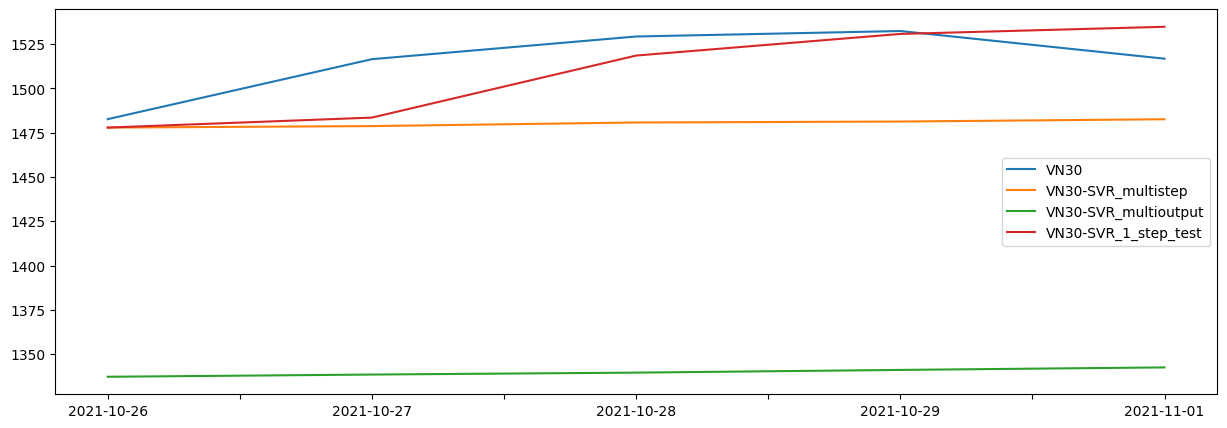

In [ ]:
stock_price_df[multistep_idx][['VN30', 'VN30-SVR_multistep', 'VN30-SVR_multioutput', 'VN30-SVR_1_step_test']].plot(figsize=(15,5))

In [25]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [26]:
test = stock_price_df.copy()[['VN30-SVR_multistep', 'VN30-SVR_multioutput', 'VN30']]
test.dropna(inplace=True)
print('\nForecast Accuracy of Incremental multistep (base on one step ahead): VN30')
accuracy_prod = forecast_accuracy(test['VN30-SVR_multistep'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
print('\nForecast Accuracy of Multi output model n_step ahead: VN30')
accuracy_prod = forecast_accuracy(test['VN30-SVR_multioutput'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

KeyError: "['VN30-SVR_multioutput'] not in index"

In [ ]:
accuracy_prod = forecast_accuracy(test['VN30-SVR_multioutput'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  0.1158
me     :  -175.6883
mae    :  175.6883
mpe    :  -0.1158
rmse   :  176.4627
corr   :  0.6398
minmax :  0.1158


In [27]:
print('\nForecast Accuracy of One-step ahead: VN30')
test = stock_price_df.copy()[['VN30-SVR_1_step_test', 'VN30']]
test.dropna(inplace=True)
accuracy_prod = forecast_accuracy(test['VN30-SVR_1_step_test'].values, test['VN30'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of One-step ahead: VN30
mape   :  0.0112
me     :  3.0201
mae    :  14.0341
mpe    :  0.0025
rmse   :  19.6125
corr   :  0.995
minmax :  0.011


<Axes: >

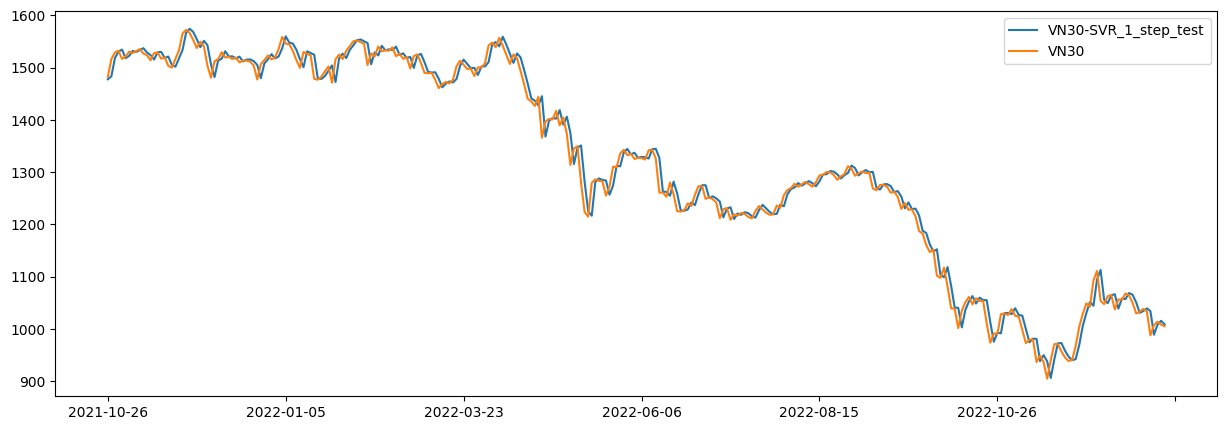

In [ ]:
test.plot(figsize=(15,5))